In [1]:
import scanpy as sc
import seaborn as sns
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
# 设置参数
mpl.rcParams["pdf.fonttype"] = 42  # 保留字体
sc.settings.verbosity = 4  # 输出细节
sc._settings.ScanpyConfig.n_jobs = -1  # 使用所有核心
sc.settings.set_figure_params(
    dpi=80,
    dpi_save=600,
    facecolor="white",
    frameon=False,  # remove frame
)

In [3]:
## 13.1.2 准备R环境
import numpy as np
import pandas as pd
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri, numpy2ri

numpy2ri.activate()
pandas2ri.activate() # type: ignore

%load_ext rpy2.ipython 

# 正式分析

- 6.标准化
- 7.去批次
- 8.聚类
- 9.细胞注释
- 10.差异分析


6.标准化

- 6.1 读取质控后的数据
- 6.2 标准化前检查
- 6.3 基本对数标准化
- 6.4 反卷积标准化：基于池化的尺寸因子估计
- 6.5 正则化负二项式回归：皮尔逊残差标准化
- 6.6 保存

---

皮尔逊残差适合发现新细胞,移位对数稳定适合 PCA
TODO:对数化等标准化后方差不稳定,参考 bioconductor


In [4]:
## 6.1 读取所有质控后的数据
adata = sc.read("anndata_scrublet.h5ad")  # "anndata_scrublet.h5ad"s

/home/fanxi/miniconda3/envs/lang/lib/python3.11/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [5]:
adata

AnnData object with n_obs × n_vars = 100484 × 17269
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'keep', 'RNA_snn_res.0.3', 'RNA_snn_res.0.6', 'RNA_snn_res.1', 'RNA_snn_res.1.2', 'seurat_clusters', 'pANN', 'DF.classifications', 'RNA_snn_res.1.4', 'RNA_snn_res.1.6', 'cell_type', 'ident', 'sample', 'group', 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_genes', 'outlier', 'mt_outlier', 'discard', 'doublet_score', 'predicted_doublet'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', '

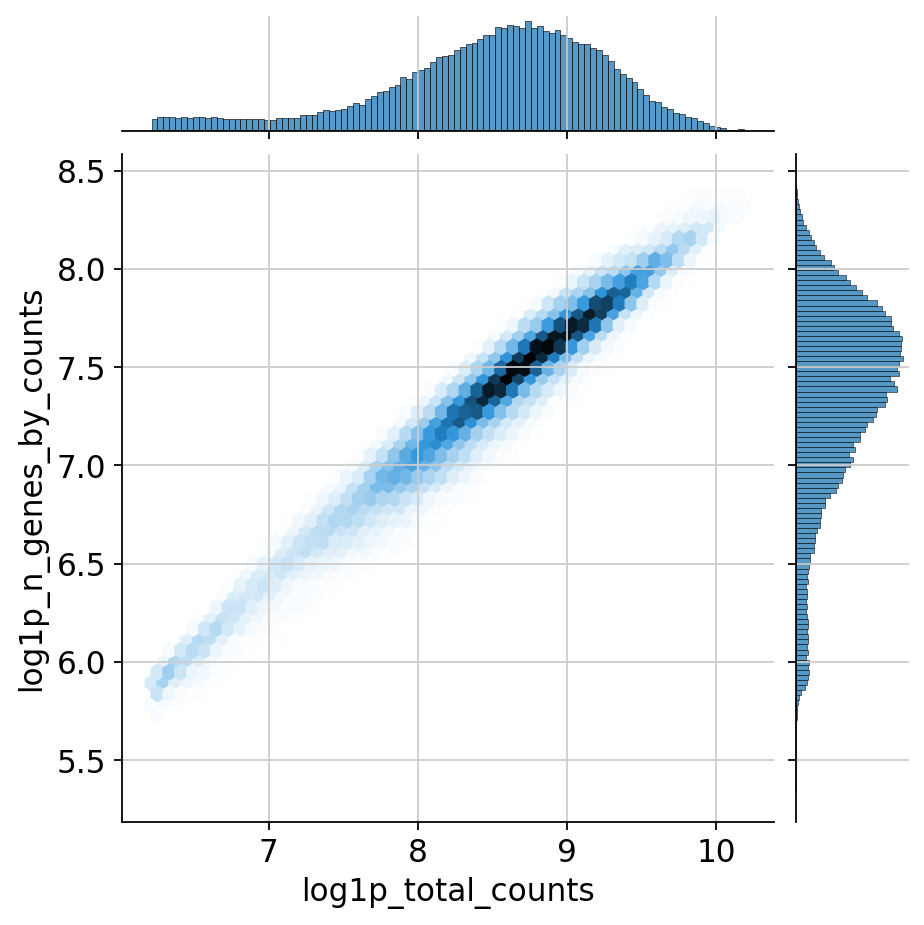

In [6]:
## 6.2 标准化前检查
"""
    - 通过所有基因的总计数对每个细胞进行标准化，
    - 以便标准化后每个细胞具有相同的总计数
    -------------------------------
    - TODO:绘图发现calculate_qc_metrics已经标准化,近似正态
    - TODO:但是之前检查表达矩阵没有改变,inplace已经检查过了
    - TODO:原始数据也还是整数counts
"""

# 发现基本成正态就不管了,数据本身可能是标准化的
# sns.histplot(adata.obs["total_counts"], bins=100, kde=False)
sns.jointplot(
    adata.obs, x="log1p_total_counts", y="log1p_n_genes_by_counts", kind="hex"
)

In [7]:
# 过滤

# adata = adata[adata.obs["log1p_total_counts"] < 7, :]
# adata = adata[adata.obs["log1p_n_genes_by_counts"] < 6.5, :]
adata

AnnData object with n_obs × n_vars = 100484 × 17269
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'keep', 'RNA_snn_res.0.3', 'RNA_snn_res.0.6', 'RNA_snn_res.1', 'RNA_snn_res.1.2', 'seurat_clusters', 'pANN', 'DF.classifications', 'RNA_snn_res.1.4', 'RNA_snn_res.1.6', 'cell_type', 'ident', 'sample', 'group', 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_genes', 'outlier', 'mt_outlier', 'discard', 'doublet_score', 'predicted_doublet'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', '

normalizing counts per cell
    finished (0:00:00)


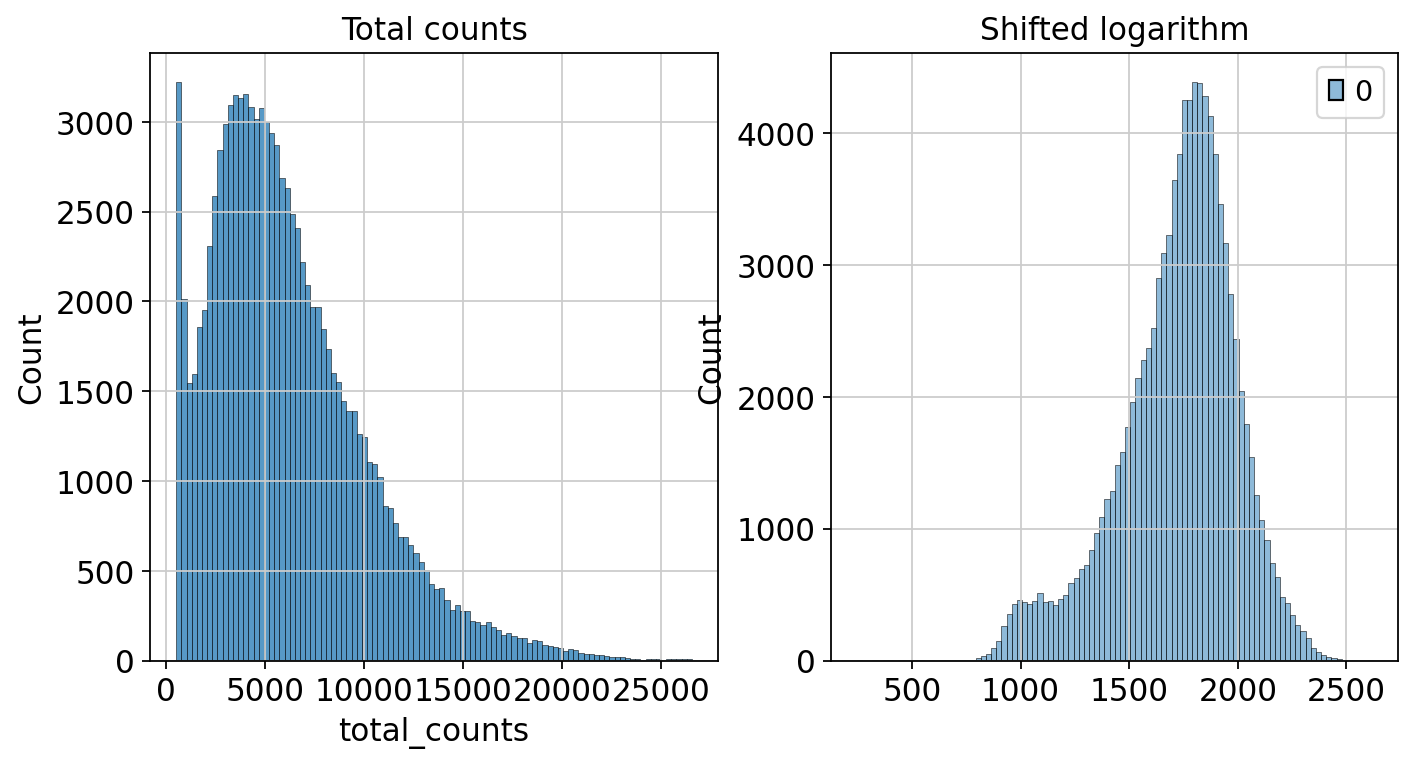

In [8]:
## 6.3 基本对数标准化
"""Normalization using sc.pp.normalize_total
   - 基于delta方法的移位对数
   - 优于其他揭示数据集潜在结构的方法（特别是在进行主成分分析时）
   - 并且有利于稳定方差，以进行后续的降维和差异表达基因的识别
"""
scales_counts = sc.pp.normalize_total(
    adata, target_sum=None, inplace=False
)  # inplace=True 直接原对象上修改
# log1p transform
adata.layers["log1p_norm"] = sc.pp.log1p(scales_counts["X"], copy=True)
# %%
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
p1 = sns.histplot(adata.obs["total_counts"], bins=100, kde=False, ax=axes[0])
axes[0].set_title("Total counts")
p2 = sns.histplot(adata.layers["log1p_norm"].sum(1), bins=100, kde=False, ax=axes[1])
axes[1].set_title("Shifted logarithm")
plt.savefig("figures/03-基本对数标准化.pdf")
plt.show()

In [9]:
## 6.4 反卷积标准化：基于池化的尺寸因子估计
"""Normalization using scran
    - 利用反卷积方法根据基于池化的的线性回归来估计大小因子。
    - 旨在更好地解释数据集中所有细胞计数深度的差异
"""
from scipy.sparse import csr_matrix, issparse

# scran 需要粗聚类输入来提高尺寸因子估计性能。
# Preliminary clustering for differentiated normalisation
adata_pp = adata.copy()
# sc.pp.normalize_total(adata_pp)  # TODO:加了这之后反卷积基本失效，但是官网例子加了这个
sc.pp.log1p(adata_pp)  # sce流程不提前log1p，我这里加了毛刺减少了，形状不变
sc.pp.pca(adata_pp, n_comps=15)
sc.pp.neighbors(adata_pp)
sc.tl.leiden(adata_pp, key_added="groups")

computing PCA
    with n_comps=15
    finished (0:00:20)
    and added
    'X_pca', the PCA coordinates (adata.obs)
    'PC1', 'PC2', ..., the loadings (adata.var)
    'pca_variance', the variance / eigenvalues (adata.uns)
    'pca_variance_ratio', the variance ratio (adata.uns)
computing neighbors
    computing neighbors
    using 'X_pca' with n_pcs = 15
    computed neighbors (0:00:23)
    computed connectivities (0:00:06)
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:30)
running Leiden clustering
    finished: found 33 clusters and added
    'groups', the cluster labels (adata.obs, categorical) (0:00:24)


In [10]:
## 6.4.1 准备表达矩阵和粗聚类分组的数据传递给R
data_mat = adata_pp.X.T
# convert to CSC if possible. See https://github.com/MarioniLab/scran/issues/70
"""
    - 检查非零元素的数量是否大于32位整数
    - 对于具有大量非零元素的矩阵,COO格式比CSC格式更节省内存。
"""
if issparse(data_mat):
    if data_mat.nnz > 2**31 - 1:
        data_mat = data_mat.tocoo()
    else:
        data_mat = data_mat.tocsc()

input_groups = adata_pp.obs["groups"]
# # 可以和之前一样直接 %%R -i input_groups -i data_mat

del adata_pp

In [11]:
data_mat = data_mat.toarray()

In [12]:
%%R -i input_groups -i data_mat -o size_factors
library(scran)
library(BiocParallel)

size_factors = sizeFactors(
    computeSumFactors(
        SingleCellExperiment(
            list(counts=data_mat)),
            clusters = input_groups,
            min.mean = 0.1,
            BPPARAM = MulticoreParam(workers = 100) # 10核
    )
)

R[write to console]: Loading required package: SingleCellExperiment

R[write to console]: Loading required package: SummarizedExperiment

R[write to console]: Loading required package: MatrixGenerics

R[write to console]: Loading required package: matrixStats

R[write to console]: 
Attaching package: ‘MatrixGenerics’


R[write to console]: The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowC

In [13]:
## 6.4.3 整合scran标准化结果到scran_normalization层
adata.obs["size_factors"] = size_factors
scran = adata.X / adata.obs["size_factors"].values[:, None]
adata.layers["scran_normalization"] = csr_matrix(sc.pp.log1p(scran))

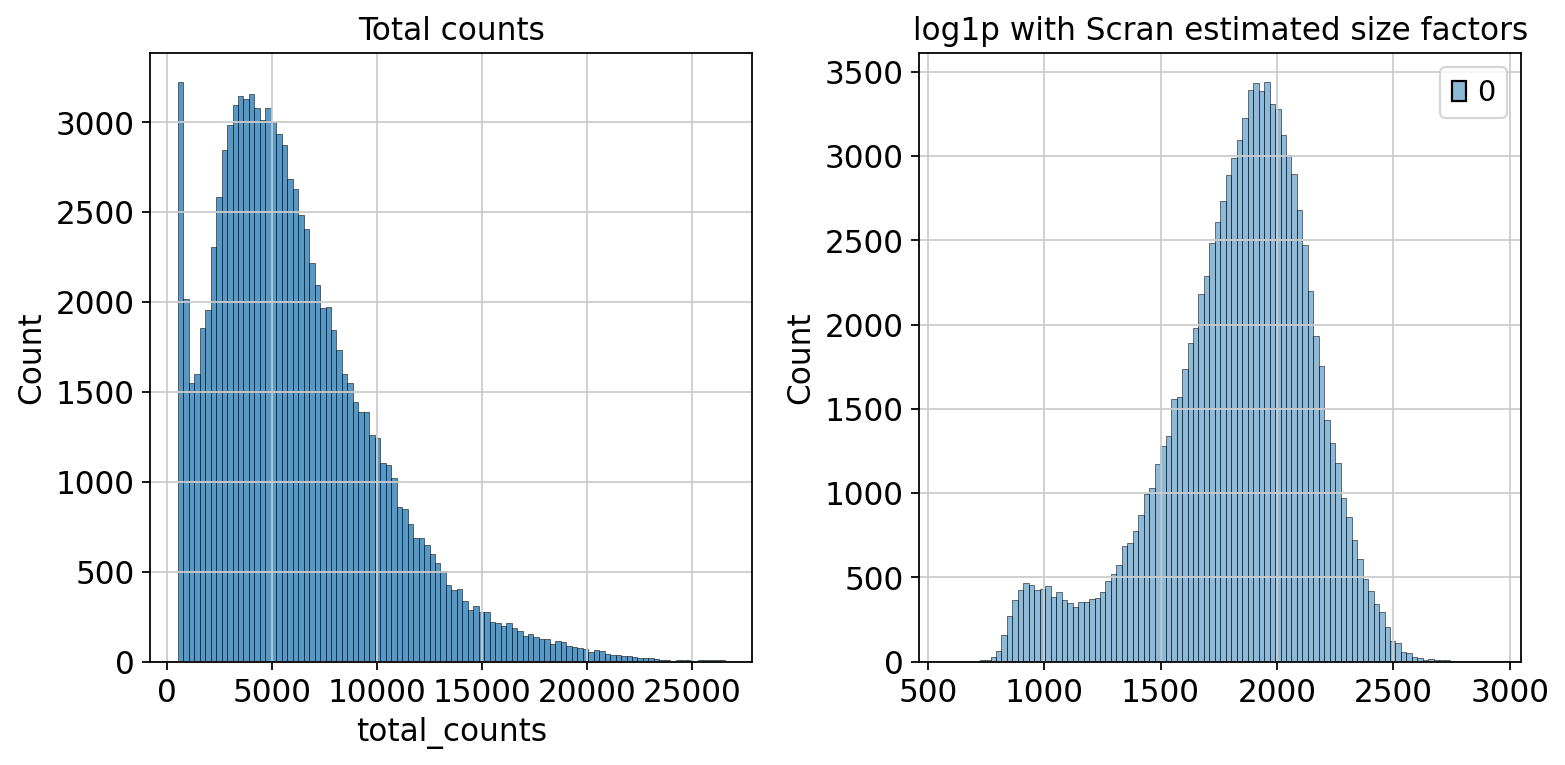

In [14]:
## 6.4.4 绘制scran标准化结果
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
p1 = sns.histplot(adata.obs["total_counts"], bins=100, kde=False, ax=axes[0])
axes[0].set_title("Total counts")
p2 = sns.histplot(
    adata.layers["scran_normalization"].sum(1), bins=100, kde=False, ax=axes[1]
)  # sum(1)数据矩阵中每行的总和，即每个细胞的总计数。沿着第二个维度（列）求和
axes[1].set_title("log1p with Scran estimated size factors")

plt.tight_layout()
plt.savefig("figures/03-标准化-scran_normalization.pdf",bbox_inches='tight', dpi=300)
plt.show()

In [15]:
## 6.5 正则化负二项式回归：皮尔逊残差标准化
"""Normalization using pearson residuals
    - “正则化负二项式回归”的皮尔逊残差来计算数据中的技术噪声模型。
    - 明确地将计数深度添加为广义线性模型中的协变量
    - 消除了采样效应的影响，同时保留了数据集中的细胞异质性。
    - 分析皮尔逊残差不需要下游启发式步骤，例如伪计数加法或对数转换。
    - 此方法的输出是标准化值，可以是正值，也可以是负值。
"""
# 皮尔逊残差标准化
# from scipy.sparse import csr_matrix

# adata.layers["sqrt_norm"] = np.sqrt(
#     sc.pp.normalize_total(adata, target_sum=1e6, inplace=False)["X"]
# )
# analytic_pearson = sc.experimental.pp.normalize_pearson_residuals(adata, inplace=False)
# adata.layers["analytic_pearson_residuals"] = csr_matrix(analytic_pearson["X"])

'Normalization using pearson residuals\n    - “正则化负二项式回归”的皮尔逊残差来计算数据中的技术噪声模型。\n    - 明确地将计数深度添加为广义线性模型中的协变量\n    - 消除了采样效应的影响，同时保留了数据集中的细胞异质性。\n    - 分析皮尔逊残差不需要下游启发式步骤，例如伪计数加法或对数转换。\n    - 此方法的输出是标准化值，可以是正值，也可以是负值。\n'

In [16]:
## 6.5.1 绘制皮尔逊残差标准化结果
# fig, axes = plt.subplots(1, 2, figsize=(8, 4))
# p1 = sns.histplot(adata.obs["total_counts"], bins=100, kde=False, ax=axes[0])
# axes[0].set_title("Total counts")
# p2 = sns.histplot(
#     adata.layers["analytic_pearson_residuals"].sum(1), bins=100, kde=False, ax=axes[1]
# )
# axes[1].set_title("Analytic Pearson residuals")
# plt.show()

In [17]:
## 6.6 保存
adata.write("anndata_normalization.h5ad", compression="gzip")  # type: ignore